## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from scipy.stats import spearmanr
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5 as TextDataset
from bert import CustomBert3
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed
from utils.torch import to_cpu

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 32.2 s, sys: 244 ms, total: 32.5 s
Wall time: 32.6 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2

## Training model

In [8]:
device = 'cuda'
pretrained_model = 'siamese_bert_5'
model_name = 'siamese_bert_6'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [9]:
def load_model(checkpoint_file, model):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    
def get_pretrained_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{pretrained_model}_fold_{fold_id+1}_best.pth'
    model = CustomBert3(256, cat_features_train.shape[1])
    load_model(checkpoint_file, model)
    return model

def load_head(model, fold_id):
    checkpoint_file = f'{checkpoint_dir}{model_name}_fold_{fold_id+1}_best.pth'
    load_model(checkpoint_file, model.head)

def save_model(model):
    checkpoint_file = f'{checkpoint_dir}{model_name}_comb_fold_{fold_id+1}_best.pth'
    torch.save({'model_state_dict': model.state_dict()}, checkpoint_file)
    
def load_saved_model(model):
    checkpoint_file = f'{checkpoint_dir}{model_name}_comb_fold_{fold_id+1}_best.pth'
    load_model(checkpoint_file, model)

In [10]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    
    model = get_pretrained_model(fold_id)
    load_head(model, fold_id)
    model.half()
    save_model(model)
    load_saved_model(model)
    model.float()
    
    oofs[valid_index] = infer(model, valid_loader, None, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    del model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

Fold 1 started at Wed Jan 29 20:13:29 2020



Averaged Val. score: 0.42102484916200233
Fold 2 started at Wed Jan 29 20:13:54 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



Averaged Val. score: 0.4229482451426362
Fold 3 started at Wed Jan 29 20:14:18 2020



Averaged Val. score: 0.3979015789472598
Fold 4 started at Wed Jan 29 20:14:41 2020



Averaged Val. score: 0.3981118204195437
Fold 5 started at Wed Jan 29 20:15:05 2020



Averaged Val. score: 0.4050767697630596
Fold 6 started at Wed Jan 29 20:15:29 2020



Averaged Val. score: 0.39476879457851694
Fold 7 started at Wed Jan 29 20:15:54 2020



Averaged Val. score: 0.41471679667783107
Fold 8 started at Wed Jan 29 20:16:18 2020



Averaged Val. score: 0.4173300395509714
Fold 9 started at Wed Jan 29 20:16:44 2020



Averaged Val. score: 0.4035814584963382
Fold 10 started at Wed Jan 29 20:17:08 2020



Averaged Val. score: 0.41993966648249365
OOF score: 0.4103081970740995


In [11]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

0 5 0.36190448626242133
0 10 0.37914820646773456
0 20 0.38142530034246525
0 33 0.381429976425864
0 100 0.38258949688321475
0 200 0.3827096859797003
1 5 0.64412835726348
1 10 0.659170943615495
1 15 0.6606271496224287
1 20 0.6631700302208924
1 33 0.6638657189422685
1 100 0.6643403775627362
2 5 0.47587251264865604
2 10 0.48082563006108464
3 5 0.28167242577947166
3 10 0.2984932352761913
3 15 0.2986298487835321
3 20 0.302169714760532
4 5 0.3618885920078353
5 5 0.4579385352463229
6 5 0.30558322996163395
6 10 0.34099018940948433
6 15 0.34858547657400074
6 20 0.3519233396273299
7 5 0.4989513708915308
7 10 0.5073938565576411
7 15 0.5082434166161479
8 5 0.5806065279741521
8 10 0.5839301178086679
9 5 0.04310947475141954
9 10 0.06875176106423303
9 15 0.11396552360518175
9 20 0.13579717930479937
10 5 0.4527823066182365
10 10 0.4648257472847197
10 15 0.4653020823031659
10 20 0.4663721812830919
10 33 0.469643130000392
11 5 0.747434426056657
11 10 0.7493902666987369
12 5 0.50132756145013
13 5 0.182965

In [12]:
np.array(opt_ds), np.array(opt_indices)

(array([200, 100,  10,  20,   5,   5,  20,  15,  10,  20,  33,  10,   5,
         15,  10,   5,  15,  33,  15, 100,  33,  15, 100,  33, 200, 100,
         33]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        18, 19, 20, 21, 23, 24, 26, 27, 28, 29]))

In [13]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [14]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.410308
CV unique rows,0.373700
CV ignoring hard targets,0.433768
CV unique rows ignoring hard targets,0.394195
CV w rounding,0.451905
CV unique rows w rounding,0.431156
CV ignoring hard targets w rounding,0.459904
CV unique rows ignoring hard targets w rounding,0.426784


In [15]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.414360
CV unique rows,0.377833
CV ignoring hard targets,0.433768
CV unique rows ignoring hard targets,0.394195
CV w rounding,0.451905
CV unique rows w rounding,0.431156
CV ignoring hard targets w rounding,0.459904
CV unique rows ignoring hard targets w rounding,0.426784


In [16]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [17]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.769430,0.630320,0.253264,0.505990,0.548395,0.393929,0.584657,0.495126,0.494235,0.008822,0.740954,0.366444,0.433643,0.107983,0.023199,0.234270,0.222907,0.128172,0.610518,0.006260,0.762534,0.869347,0.560988,0.933016,0.897846,0.646029,0.099785,0.112461,0.919749,0.692573
1,0.832214,0.743500,0.035179,0.529389,0.893494,0.707537,0.474991,0.530408,0.314136,0.000984,0.300907,0.075210,0.822658,0.004980,0.502573,0.037238,0.058692,0.055789,0.450338,0.001863,0.759211,0.494612,0.281495,0.706844,0.713284,0.315157,0.029875,0.038480,0.557189,0.749671
2,0.598315,0.197569,0.005910,0.742580,0.771822,0.865638,0.486866,0.310613,0.213526,0.001237,0.359968,0.300548,0.005783,0.003519,0.000628,0.316318,0.698185,0.242201,0.115033,0.000058,0.495096,0.836340,0.577780,0.882220,0.874495,0.658584,0.627916,0.302123,0.432792,0.719899
3,0.771622,0.664281,0.404273,0.681201,0.610846,0.703084,0.588372,0.718686,0.197056,0.002132,0.484943,0.927750,0.015534,0.020429,0.016212,0.010247,0.030881,0.172874,0.510900,0.000727,0.822699,0.808290,0.797410,0.818556,0.919759,0.769655,0.078427,0.242776,0.831951,0.789403
4,0.757833,0.684782,0.003993,0.712469,0.832895,0.921952,0.479544,0.427637,0.181981,0.002871,0.267267,0.538496,0.001793,0.000952,0.001811,0.005908,0.821427,0.289639,0.190004,0.000192,0.759721,0.740275,0.423894,0.798693,0.896764,0.566158,0.935835,0.205579,0.029313,0.530111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.832756,0.297409,0.195229,0.803169,0.701334,0.671199,0.734670,0.722870,0.647168,0.001983,0.566897,0.914643,0.183645,0.144633,0.019472,0.134283,0.018541,0.031876,0.510902,0.002323,0.647581,0.858424,0.763505,0.929481,0.894224,0.694258,0.070823,0.078730,0.881910,0.662090
6075,0.884007,0.408054,0.112815,0.519946,0.417607,0.314707,0.755898,0.777282,0.043668,0.003478,0.827156,0.009875,0.005366,0.008655,0.000254,0.018723,0.837352,0.370381,0.194823,0.000058,0.755254,0.851541,0.603084,0.915214,0.941134,0.620963,0.802967,0.381465,0.376682,0.892396
6076,0.521837,0.220227,0.002096,0.692448,0.777233,0.907758,0.389980,0.249781,0.115602,0.001546,0.454593,0.381886,0.000647,0.000334,0.000371,0.001743,0.863123,0.409436,0.195855,0.000009,0.326356,0.391128,0.292885,0.651422,0.760464,0.266966,0.530686,0.158055,0.398835,0.168377
6077,0.827769,0.570298,0.688386,0.234038,0.292316,0.100554,0.578670,0.724366,0.801219,0.001176,0.922197,0.658408,0.261404,0.168003,0.005722,0.028570,0.033541,0.137513,0.795767,0.000154,0.862363,0.682089,0.458803,0.851367,0.835769,0.476599,0.021189,0.049208,0.880098,0.779313


In [18]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.382647
question_body_critical                   0.664232
question_conversational                  0.414475
question_expect_short_answer             0.300372
question_fact_seeking                    0.358043
question_has_commonly_accepted_answer    0.435739
question_interestingness_others          0.351191
question_interestingness_self            0.507711
question_multi_intent                    0.581136
question_not_really_a_question           0.097234
question_opinion_seeking                 0.469577
question_type_choice                     0.738792
question_type_compare                    0.355668
question_type_consequence                0.177909
question_type_definition                 0.361711
question_type_entity                     0.444166
question_type_instructions               0.777344
question_type_procedure                  0.352743
question_type_reason_explanation         0.664930
question_type_spelling                   0.066497


In [19]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.066497,3.0
question_not_really_a_question,0.097234,5.0
answer_plausible,0.130899,9.0
answer_relevance,0.162598,9.0
question_type_consequence,0.177909,5.0
answer_well_written,0.232796,9.0
answer_helpful,0.236442,9.0
question_expect_short_answer,0.300372,5.0
answer_type_procedure,0.304955,5.0
answer_satisfaction,0.332160,17.0


In [20]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

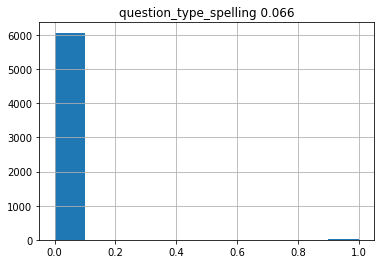

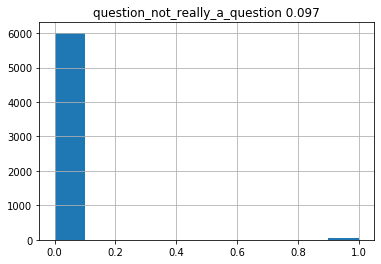

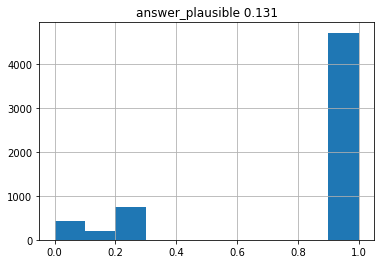

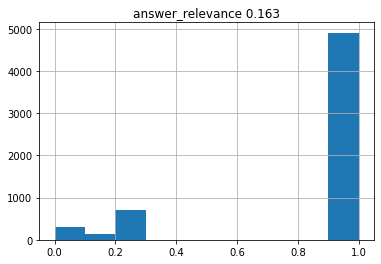

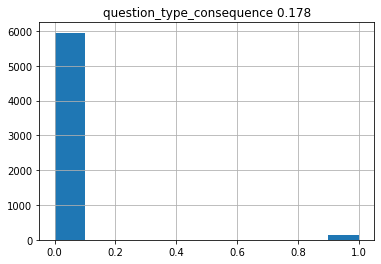

In [21]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


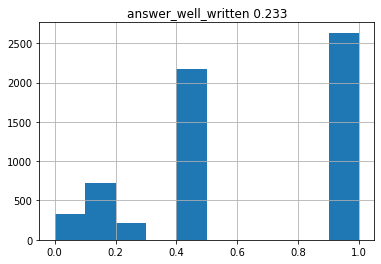

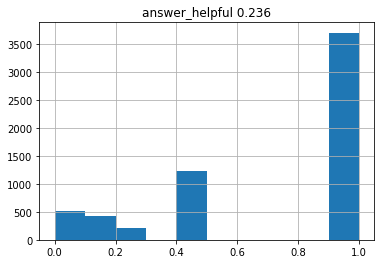

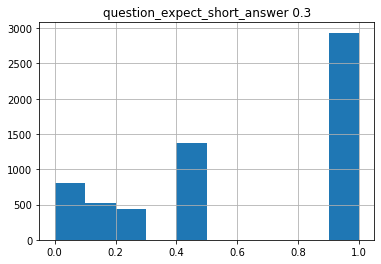

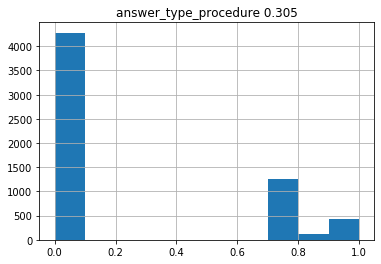

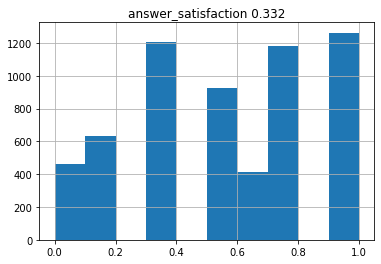

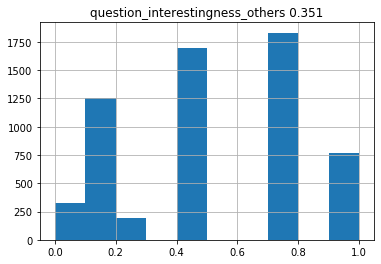

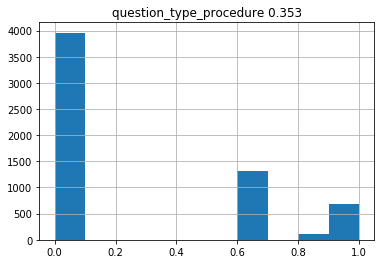

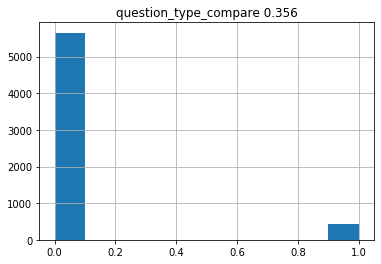

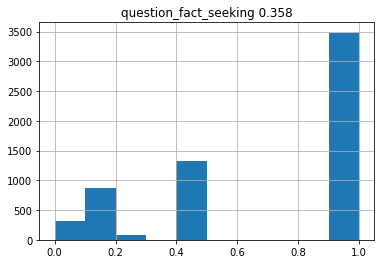

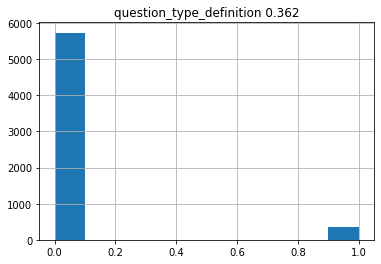

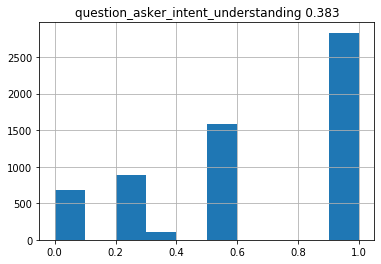

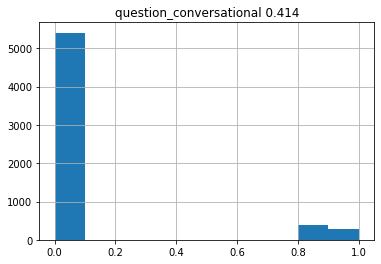

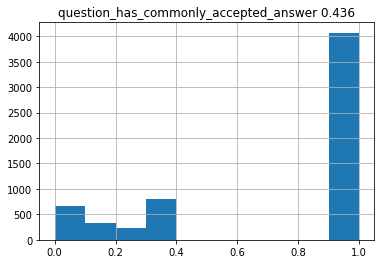

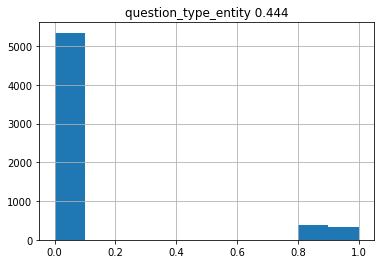

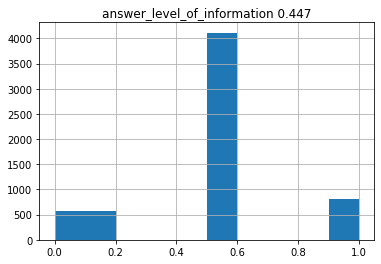

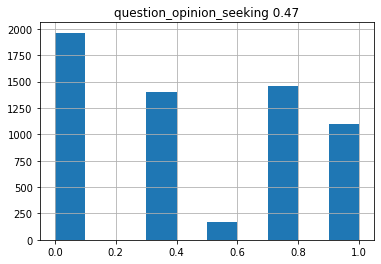

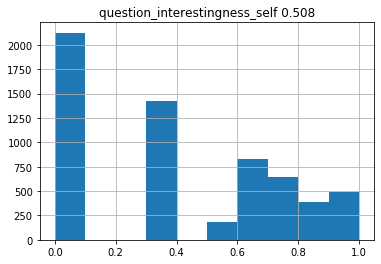

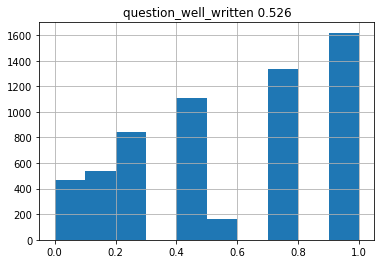

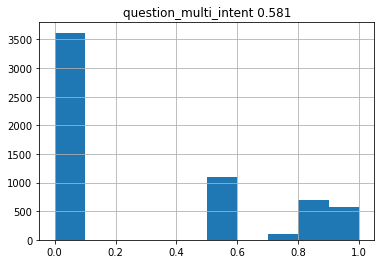

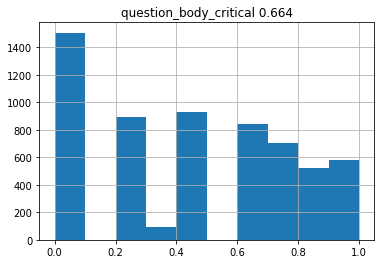

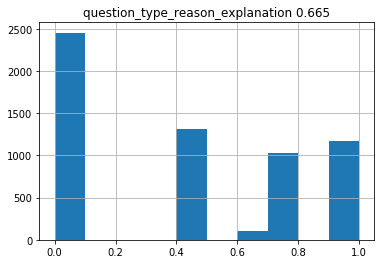

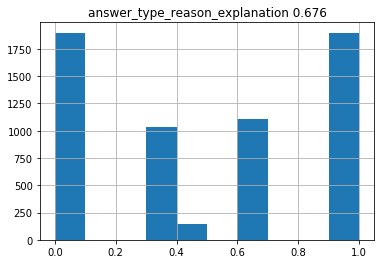

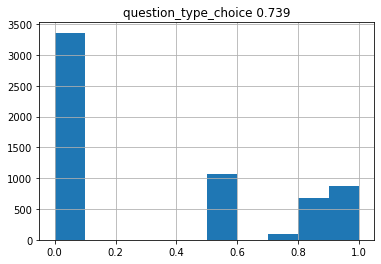

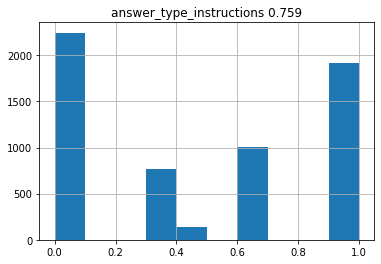

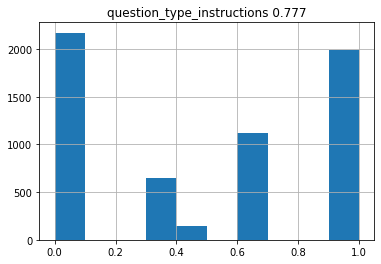

In [22]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')